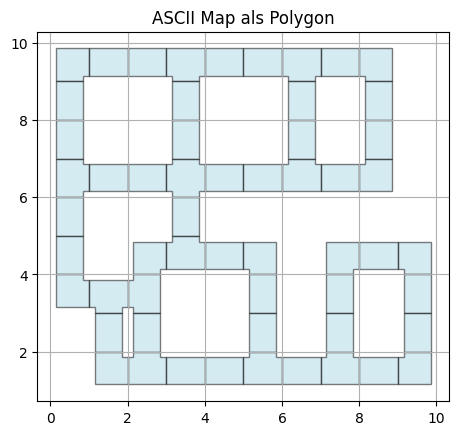

In [16]:
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt

# Deine ASCII-Map als Grid
grid = [
    ['┌', '─', '─', '┬', '─', '─', '┬', '─', '┐', ' '],
    ['│', ' ', ' ', '│', ' ', ' ', '│', ' ', '│', ' '],
    ['│', ' ', ' ', '│', ' ', ' ', '│', ' ', '│', ''],
    ['├', '─', '─', '┼', '─', '─', '┴', '─', '┘', ' '],
    ['│', ' ', ' ', '│', ' ', ' ', ' ', ' ', ' ', ' '],
    ['│', ' ', '┌', '┴', '─', '┐', ' ', '┌', '─', '┐'],
    ['└', '┬', '┤', ' ', ' ', '│', ' ', '│', ' ', '│'],
    [' ', '│', '│', ' ', ' ', '│', ' ', '│', ' ', '│'],
    [' ', '└', '┴', '─', '─', '┴', '─', '┴', '─', '┘'],
    [' ', '', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
]
cell_size = 1.0
margin = 0.15  # halbe Straßenbreite

def symbol_to_polygon(i, j, symbol, rows, cols, cell_size=1.0, m=0.1):
    x0 = j * cell_size
    y0 = (rows - 1 - i) * cell_size
    x1 = x0 + cell_size
    y1 = y0 + cell_size
    xm = x0 + m
    xM = x1 - m
    ym = y0 + m
    yM = y1 - m

    if symbol == '─':
        return Polygon([(x0, ym), (x1, ym), (x1, yM), (x0, yM)])
    elif symbol == '│':
        return Polygon([(xm, y0), (xM, y0), (xM, y1), (xm, y1)])
    elif symbol == '┌':
        return Polygon([(xm, y0), (xM, y0), (xM, ym), (x1, ym), (x1, yM), (xm, yM)])
    elif symbol == '┐':
        return Polygon([(x0, yM), (xM, yM), (xM, y0), (xm, y0), (xm, ym), (x0, ym)])
    elif symbol == '└':
        return Polygon([(xm, y1), (xm, ym), (x1, ym), (x1, yM), (xM , yM), (xM, y1)])
    elif symbol == '┘':
        return Polygon([(x0, ym), (xM, ym), (xM, y1), (xm, y1), (xm, yM), (x0, yM)])
    elif symbol == '├':
        return Polygon([(xm, y0), (xM, y0), (xM, ym), (x1, ym), (x1, yM), (xM, yM), (xM, y1), (xm, y1)])
    elif symbol == '┤':
        return Polygon([(xm, y0), (xM, y0), (xM, y1), (xm, y1), (xm, yM), (x0, yM), (x0, ym), (xm, ym)])
    elif symbol == '┬':
        return Polygon([(x0, ym), (xm, ym), (xm, y0), (xM, y0), (xM, ym), (x1, ym), (x1, yM), (x0, yM)])
    elif symbol == '┴':
        return Polygon([(x0, ym), (x1, ym), (x1, yM), (xM, yM), (xM, y1), (xm, y1), (xm, yM), (x0, yM)])
    elif symbol == '┼':
        return Polygon([(xm, y0), (xM, y0), (xM, ym), (x1, ym), (x1, yM), (xM, yM), (xM, y1),
                        (xm, y1), (xm, yM), (x0, yM), (x0, ym), (xm, ym)])
    return None

def ascii_grid_to_polygons(grid, cell_size=1.0, margin=0.1):
    rows = len(grid)
    cols = len(grid[0])
    polygons = []
    for i in range(rows):
        for j in range(cols):
            symbol = grid[i][j]
            poly = symbol_to_polygon(i, j, symbol, rows, cols, cell_size, margin)
            if poly:
                polygons.append(poly)
    return polygons

def plot_polygons(polygons):
    fig, ax = plt.subplots()
    for poly in polygons:
        x, y = poly.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='lightblue', ec='black')
    ax.set_aspect('equal')
    ax.set_title("ASCII Map als Polygon")
    plt.grid(True)
    plt.show()

# Main-Ausführung
polys = ascii_grid_to_polygons(grid, cell_size, margin)
plot_polygons(polys)

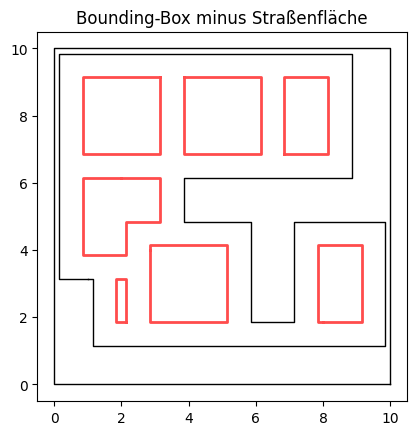

In [ ]:
from shapely.geometry import box
from shapely.ops import unary_union

# Angenommen, `grid_polys` ist die Liste aller Straßen-Polygone,
# erzeugt z.B. durch ascii_grid_to_polygons(...)
# und grid hat die Abmessungen rows×cols.

rows = len(grid)
cols = len(grid[0])
cell_size = 1.0

# 1. Vereine alle Straßen-Segmente in ein Multi-/Polygon
# Erzeuge eine Union der Straßenpolygone, so dass die Löcher (Innenflächen) erhalten bleiben
roads = unary_union(polys)

# Die Löcher (Innenringe) extrahieren:
holes = []
if roads.geom_type == "Polygon":
    for hole in roads.interiors:
        holes.append(Polygon(hole))
elif roads.geom_type == "MultiPolygon":
    for poly in roads.geoms:
        for hole in poly.interiors:
            holes.append(Polygon(hole))
roads = roads.buffer(0)
fig, ax = plt.subplots()

# Bounding‑Box als schwarzer Rahmen
x_bb, y_bb = bb.exterior.xy
ax.plot(x_bb, y_bb, color='black', linewidth=1)

# Löcher (Innenflächen) nur rot umranden, nicht füllen
for hole_poly in holes:
    xh, yh = hole_poly.exterior.xy
    ax.plot(xh, yh, color='red', linewidth=2, alpha=0.7)

# Straßen Scharz umranden
for poly in getattr(roads, 'geoms', [roads]):
    x, y = poly.exterior.xy
    ax.plot(x, y, color='black', linewidth=1)

ax.set_aspect('equal')
ax.set_title("Bounding-Box minus Straßenfläche")
plt.show()

In [ ]:
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union

def export_to_cpp(roads, holes, filename="output/generated_maze.cpp"):
    lines = []
    lines.append('#include <iostream>')
    lines.append('#include <list>')
    lines.append('#include "maze_generator.h"\n')
    lines.append('void MazeGenerator::generateMaze()\n{')
    lines.append('    // --- Straßenpolygone ---')
    # Straßenpolygone
    road_geoms = [roads] if roads.geom_type == 'Polygon' else list(roads.geoms)
    for idx, poly in enumerate(road_geoms):
        var = f"road{idx}"
        lines.append(f"    // {var}")
        lines.append(f"    Mazepolygon {var};")
        coords = list(poly.exterior.coords)[:-1]
        for x, y in coords:
            lines.append(f"        {var}.coordinates.push_back({{{x:.2f}f, {y:.2f}f}});")
        lines.append(f"    polygons.push_back({var});\n")
    # Löcher (Innenflächen)
    lines.append('    // --- Löcher (Innenflächen) ---')
    for idx, poly in enumerate(holes):
        var = f"hole{idx}"
        lines.append(f"    // {var}")
        lines.append(f"    Mazepolygon {var};")
        coords = list(poly.exterior.coords)[:-1]
        for x, y in coords:
            lines.append(f"        {var}.coordinates.push_back({{{x:.2f}f, {y:.2f}f}});")
        lines.append(f"    polygons.push_back({var});\n")
    lines.append('    std::cout << "Maze generated!" << std::endl;')
    lines.append("}\n")
    with open(filename, "w") as f:
        f.write("\n".join(lines))
    print(f"✅ Exportiert nach {filename}")

# Beispielaufruf (nachdem roads und holes erzeugt wurden):
export_to_cpp(roads, holes)